# FINM 33150 Project Draft - Trading Volatility with VIX Forecasts

Sean Lin (12375235) | Thomas McDonnell (12365628) | Ben Panovich (12365148) | Madison Rusch (12365298)

***

## 1 Introduction

In this notebook, we show the premise and data for our quantitative trading strategy. The trading strategy will involve capitalizing on volatility in the markets VIX forecasting. The volatility will be capitalized on through 5 different asset classes. More specifically, equities, options, currencies, futures, and bonds. Each asset class has a relationship to increase in equity markets volatility and certain assets in each class will be chosen. The primary asset will be the delta-hedged option position with the other asset classes serving as diversification. In order to forecast VIX, an ARIMA model will be used.

In [32]:
import os
import pandas as pd 
import numpy as np 
import functools 
import itertools
import quandl 
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
import math
import datetime
import requests
import plotnine as p9
from plotnine import ggplot, aes, geom_histogram, labs, facet_wrap, theme, element_text, geom_line, geom_vline
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

In [3]:
KEY = os.getenv('QUANDL_KEY')
quandl.ApiConfig.api_key = KEY # Insert your key here if you want to run the code yourself 

## 2 Model Data

For daya, a variety of data sources will be used. The majority of price data will come from Quandl with historical options pricing data coming from [polygon.io](https://polygon.io). Data will also be used from external sources, mainly [investing.com](https://www.investing.com) and [fxstreet.com](https://www.fxstreet.com/economic-calendar) to obtain values needed for prediction. First, data will be obtained for the VIX predictors. To keep things organized, model data will be covered in this section while the traded data (assets that will be traded) will be covered in a later section.

***

**2.1 Helper Functions**

First, helper functions `fetch_quandl`, `fetch_quandl_table` will be defined in order to retrieve data from Quandl databases. `tail_statistics` will be used to look at kurtosis and skewness.

In [5]:
@functools.lru_cache()
def fetch_quandl(asset, begin_date=None, end_date=None):
    '''
    Retrieves Quandl data 

    Parameters:
    asset (string): Asset to be retrieved
    begin_date (string): Start date of data retrieval
    end_date (string): End date of data retrieval 

    Returns:
    qdata (DataFrame): DataFrame of asset data 
    '''
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      paginate=True)
    return qdata

In [6]:
@functools.lru_cache()
def fetch_quandl_table(table, ticker, begin_date = None, end_date = None):
    '''
    Retrieves Quandl table data 

    Parameters:
    table (string): The table to retrieve 
    ticker (string): The ticker from the table 
    begin_date (string): Start date of data retrieval
    end_date (string): End date of data retrieval 

    Returns:
    qdata (DataFrame): DataFrame of asset data 
    '''
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      qopts = {"columns":["date", "adj_close", "adj_volume"]},
                      ticker = ticker,
                      paginate=True)
    qdata = qdata.set_index('date').sort_index(ascending=True)
    return qdata

In [27]:
def tail_statistics(rets):
    '''
    Calculates common risk tail statistics for a portfolio 

    Parameters:
        rets (DataFrame): DataFrame consisting of returns 

    Returns:
        metrics (DataFrame): DataFrame consisting of the tail statistics
    '''
    metrics = pd.DataFrame(columns=rets.columns)
    metrics.loc['VaR (0.05)'] = rets.quantile(0.05)
    metrics.loc['CVaR (0.05)'] = rets[rets < rets.quantile(0.05)].mean()
    metrics.loc['Skewness'] = rets.skew()
    metrics.loc['Kurtosis'] = rets.kurt()
    return metrics

***

**2.1 Importing Model Data**

Here, we will import the data needed for VIX forecasting. This includes 5 factors: economic calendar events, S&P 500 returns, SPY volume, Shanghai Stock Exchange (SSEC) returns, and Crude Oil (CL) future returns. These factors will be used to forecast one-day-out VIX returns.

The start date and end date are first defined to save memory. These dates are based on the data obtained via the economic calendar. Predictions are limited by the economic calendar data and the initial dates are selected based on this. In the final submission, the economic calendar data will be expanded to encompass a larger range.

In [7]:
START_DATE = '2014-01-01' 
END_DATE = '2022-12-23' 

VIX data was first collected. This data was obtained from [investing.com](https://www.investing.com/indices/volatility-s-p-500)

In [10]:
filename = './data/vix_data.csv'
vix_data = pd.read_csv(filename)
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])
vix_data = vix_data.set_index('DATE')[['CLOSE']]
vix_data = vix_data.loc[START_DATE:END_DATE]

The economic calendar data is collected next. In the economic calendar, events are classified by importance. Here, only events considered *high importance* are used. The data is translated such that for any date, it counts the number of days until the next high impact news driver. For example, some high impact news drivers are FOMC, CPI, Fed Chair Speeches, and Employment Numbers, though the data may have some more examples.

In [8]:
filename = './data/economic_calendar.csv'
event_data = pd.read_csv(filename)
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

When considering days until an event, weekends must also be considered as options pricing uses the full calendar. More specifically, weekends count and this is seen when examining options prices after a weekend. Options prices (everything kept the same) will decrease over a weekend due to the effects of theta. These calculations are done below.

In [11]:
idx = vix_data.index
all_dates = pd.date_range(START_DATE,END_DATE)

temp = vix_data.copy()
temp.columns = ['VIX']
temp = temp.reindex(idx, fill_value=None)
temp['Event'] = np.where(temp.index.isin(event_data.index.values), True, False)
temp['Days until Event'] = np.where(temp['Event'] == True, 0, vix_data.groupby((temp['Event'] == True).cumsum()).cumcount(ascending=False)+1)
temp = temp.dropna(subset=['VIX'])
temp = temp[['VIX', 'Days until Event']]

Now SPY (S&P 500 ETF) will be obtained. The strategy involves trading US based equities so only US trading days should be considered. In other words, these are the dates where SPY has a close. It's important to note that some days may have early closes (i.e Thanksgiving week). This will not affect the trading strategy as our trades will be assumed to occur at the close.

In [13]:
spy_data = fetch_quandl_table('QUOTEMEDIA/PRICES','SPY',begin_date=START_DATE,end_date=END_DATE)
spy_data.columns = ['SPY', 'SPY Volume']
trading_days = spy_data.index 
temp = temp.loc[temp.index.isin(trading_days)]

The Shanghai Stock Exchange (SSEC) data will be imported here. This is used as the Shanghai Stock Exchange closes before the US Stock Exchange opens. This can potentially provide valuable information on VIX behavior throughout the day as global markets typically have some degree of correlation to one another. In other words, contemperanous returns of the SSEC can aid in VIX prediction.

In [14]:
filename = './data/ssec_data.csv'
ssec_data = pd.read_csv(filename)
ssec_data['Date'] = pd.to_datetime(ssec_data['Date'])
ssec_data = ssec_data.set_index('Date')
ssec_data = ssec_data.loc[ssec_data.index.isin(trading_days)].sort_index(ascending=True)
ssec_data = ssec_data[['Price']].rename(columns={'Price':'SSEC'})
ssec_data = ssec_data['SSEC'].str.replace(',','').astype(float).to_frame()

The last predictor we need will be crude oil future data (CL). Futures are unique in that they are derivatives and thus have quarterly expirations. Due to this fact, these contracts must be rolled over when obtaining the prices.

In [15]:
securities = ['OWF/NYM_CL_CL']
dates = ['H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020', 'M2020', 'U2020', 'Z2020',
         'H2021', 'M2021', 'U2021', 'Z2021', 
         'H2022', 'M2022', 'U2022', 'Z2022',
         'H2023']

# Fetch NYM_RB_RB Data
finalized_data = pd.DataFrame()
security = securities[0]
trim_start = START_DATE
trim_end = END_DATE
for month in tqdm(dates):
  data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
  if finalized_data.empty:
    finalized_data = data
  else:
    finalized_data = pd.concat([finalized_data, data])
  trim_start = finalized_data.index[-1] + pd.DateOffset(1)

cl_data = finalized_data.copy()[['Future']].rename(columns={'Future':'CL'})

100%|██████████| 37/37 [00:09<00:00,  4.00it/s]


With all the predictors obtained, the final DataFrame for the predictors can be created. For most assets, the prices aren't significant due to the serial correlation. The best estimate of tomorrow's price is today's price. As a result, returns should be used instead. The returns are calculated here for the different assets (VIX, SPY, SSEC, CL).

In [58]:
all_data = pd.concat([temp, spy_data, ssec_data, cl_data], axis=1)

all_data['VIX Returns'] = all_data['VIX'].pct_change()
all_data['SPY Returns'] = all_data['SPY'].pct_change()
all_data['SSEC Returns'] = all_data['SSEC'].pct_change()
all_data['CL Returns'] = all_data['CL'].pct_change()

predictors = all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].dropna()

These results aren't lagged and don't give any meaningful prediction. As mentioned earlier, the market returns of SPY, VIX, and CL should be shifted. SSEC does not need to be shifted as the Asian markets close before American markets open. For ease, VIX and SSEC was shifted backwards rather than shifting everything forwards.

It's important to note here that the economic calendar data is also contemparaneous as events are always known ahead of time (unless there are extraordinary circumstances such as COVID emergency Fed meetings). The data was not made contemparaneous here but will be done in the final version of the project.

In [59]:
# TODO: Shift economic calendar data backwards as it's also contemparaneous 
predictors['VIX Returns (y)'] = predictors['VIX Returns'].shift(-1)
predictors['SSEC Returns'] = predictors['SSEC Returns'].shift(-1)
predictors = predictors.drop(columns=['VIX Returns'])

predictors = predictors.dropna()

***

**2.2 Predictor Statistics**

Now that all the predictor data is present, let's analyze the return data on these assets.

In [60]:
all_data[['Days until Event','SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']].describe()

,Days until Event,SPY Volume,VIX Returns,SPY Returns,SSEC Returns,CL Returns
count,2262.000000,2.262000e+03,2330.000000,2330.000000,2330.000000,2330.000000
mean,1.662688,9.378756e+07,0.003514,0.000451,0.000243,0.000381
std,1.980849,4.796567e+07,0.085996,0.011138,0.013019,0.029793
min,0.000000,2.027001e+07,-0.259057,-0.109424,-0.084907,-0.433676
25%,0.000000,6.204491e+07,-0.043798,-0.003518,-0.004626,-0.011768
50%,1.000000,8.112095e+07,-0.005686,0.000441,0.000000,0.000526
75%,3.000000,1.107027e+08,0.035993,0.005394,0.005608,0.012453
max,12.000000,5.072443e+08,1.155979,0.090603,0.078403,0.250996


Some observations:
- There appears to be a high impact event every 1.66 days on average
- VIX returns have the highest maximum and it would be expected to have high skewness. This makes sense due to the nature of VIX.
- The medians of all the returns are around 0, though the VIX return is slightly negative, making sense due to its decaying nature.
- VIX also has the highest variance among the returns.

Let's look at the tail-statistics now. 

In [61]:
tail_statistics(all_data[['SPY Volume','VIX Returns','SPY Returns','SSEC Returns','CL Returns']])

,SPY Volume,VIX Returns,SPY Returns,SSEC Returns,CL Returns
VaR (0.05),4.524980e+07,-0.106780,-0.017242,-0.018641,-0.039081
CVaR (0.05),4.004717e+07,-0.141323,-0.027706,-0.033582,-0.064496
Skewness,2.258095e+00,2.452160,-0.569144,-0.774070,-0.741044
Kurtosis,8.302535e+00,19.310128,13.604275,7.682615,34.278709


Some observations
- The kurtosis among all the assets are typical of return data.
- Crude oil has the highest kurtosis while SSEC has the lowest.
- VIX has positive skewness as it can explode, as seen during COVID. 
- The CVaR of VIX is the lowest compared to other asset classes.

***

**2.3 Qualitative Representations**

Let's graphically look at these statistics.

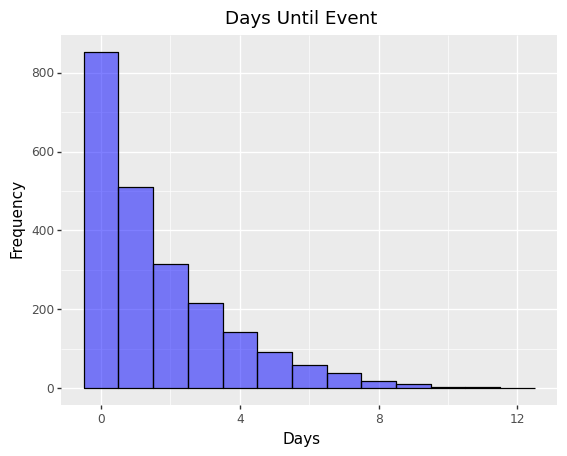

<ggplot: (698277675)>

In [62]:
(ggplot() 
 + aes(x=all_data[['Days until Event']])
 + geom_histogram(binwidth=1, color='black', fill='blue', alpha=0.5) 
 + labs(x='Days', y='Frequency', title='Days Until Event')
)

This graph makes apparent that there are high impact events on the US Dollar most days, with the majority of the data clustered around zero days until event. At the edges of the data, we have at most 12 days until an event.

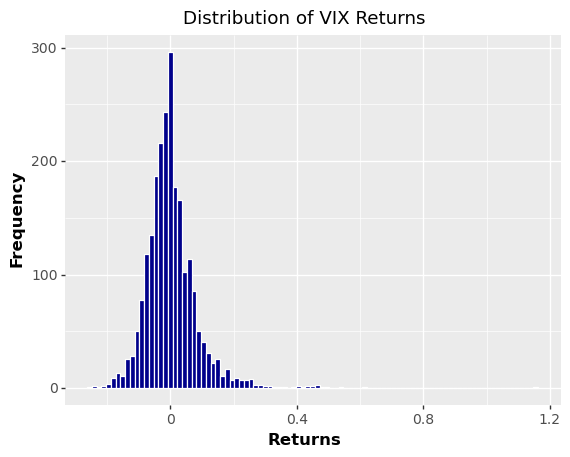

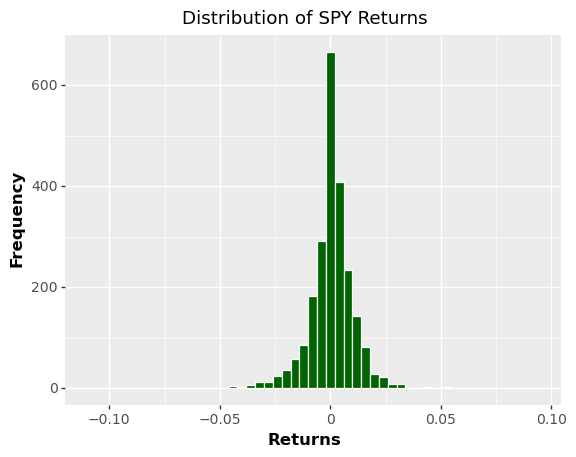

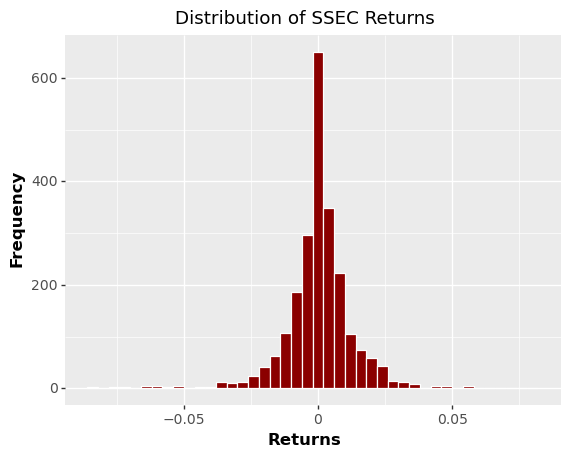

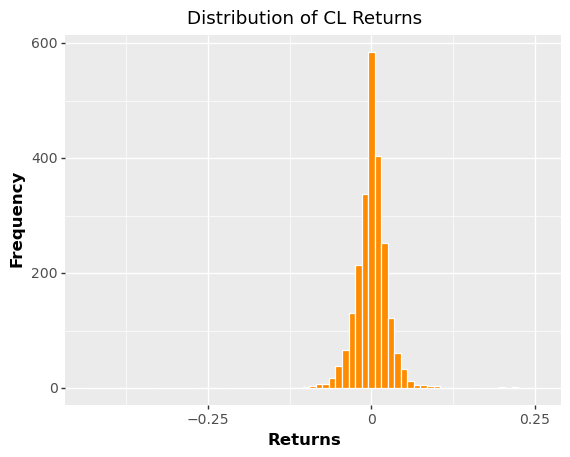

(<ggplot: (697711665)>,
 <ggplot: (697767669)>,
 <ggplot: (697649062)>,
 <ggplot: (399861529)>)

In [63]:
hist1 = (ggplot(all_data, aes(x='VIX Returns'))
         + geom_histogram(binwidth=.015, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of VIX Returns')
        )
hist2 = (ggplot(all_data, aes(x='SPY Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkgreen')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SPY Returns')
        )
hist3 = (ggplot(all_data, aes(x='SSEC Returns'))
         + geom_histogram(binwidth=.004, color='white', fill='darkred')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of SSEC Returns')
        )
hist4 = (ggplot(all_data, aes(x='CL Returns'))
                + geom_histogram(binwidth=.01, color='white', fill='darkorange')
                + theme(axis_text=element_text(size=10),
                        axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of CL Returns')
        )

hist1, hist2, hist3, hist4

From above, the quantitative statistics can be made apparent. They appear to be roughly symmetrical, but there are areas far away from the mean/median with nonzero probability density.

Now, let's show the price series of the equities and SPY volume data.

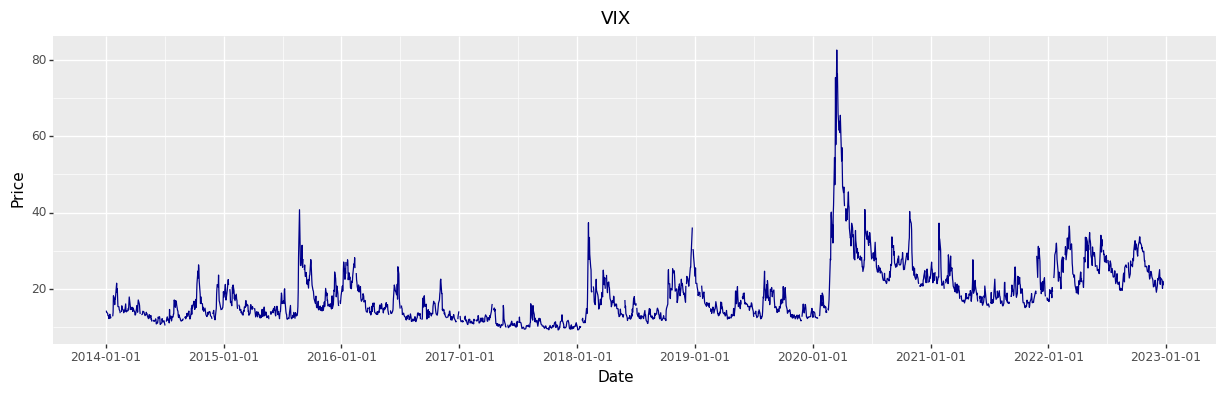

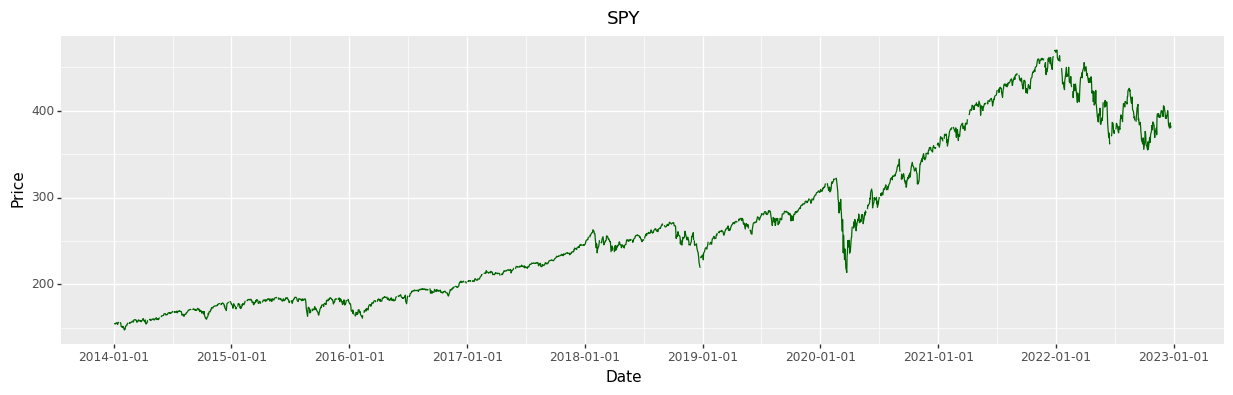

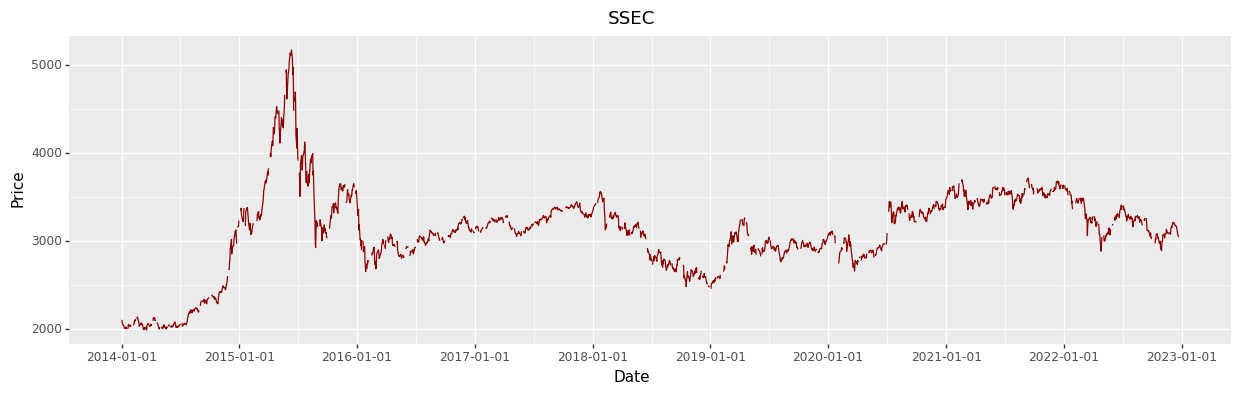

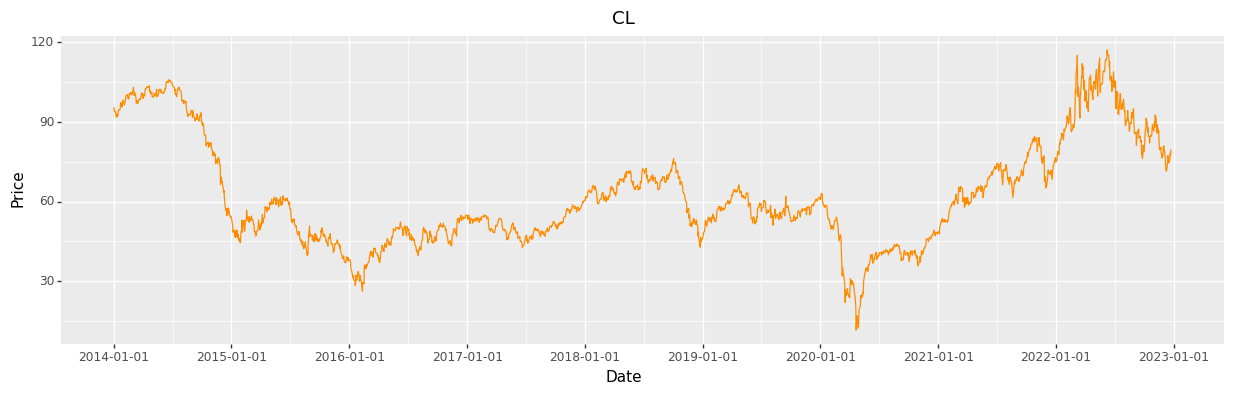

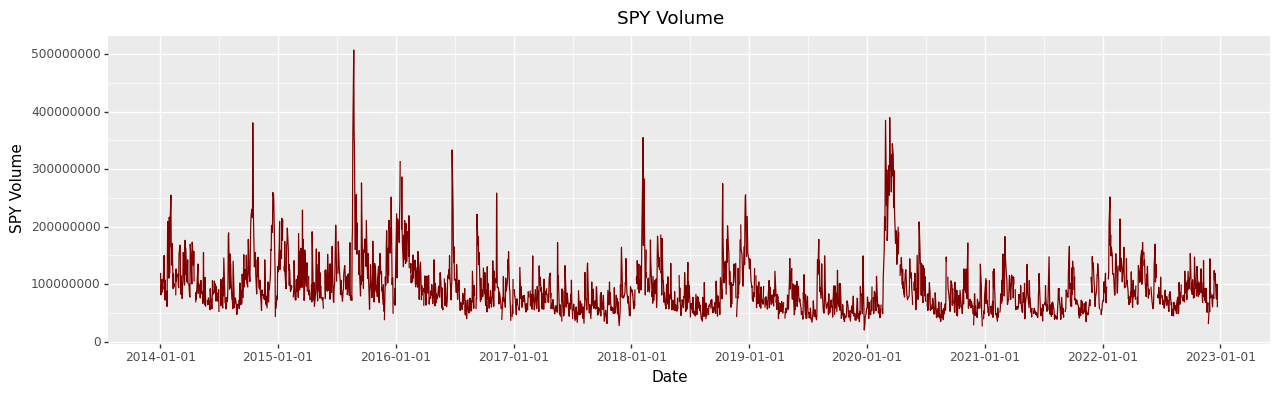

(<ggplot: (704148468)>,
 <ggplot: (704148189)>,
 <ggplot: (704188011)>,
 <ggplot: (704148255)>,
 <ggplot: (703853947)>)

In [127]:
vix = (ggplot(all_data[['VIX']], aes(x=all_data.index, y='VIX'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Price', title='VIX')
       )
spy = (ggplot(all_data[['SPY']], aes(x=all_data.index, y='SPY'))
        + geom_line(color='darkgreen')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Price', title='SPY')
        )
ssec = (ggplot(all_data[['SSEC']], aes(x=all_data.index, y='SSEC'))
        + geom_line(color='darkred')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Price', title='SSEC')
        )
cl = (ggplot(all_data[['CL']], aes(x=all_data.index, y='CL'))
        + geom_line(color='darkorange')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Price', title='CL')
        )
spy_volume = (ggplot(all_data[['SPY Volume']], aes(x=all_data.index, y='SPY Volume'))
        + geom_line(color='maroon')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='SPY Volume', title='SPY Volume')
        )
vix,spy,ssec,cl,spy_volume

Some observations:

- Oil doesn't appear to have any type of large trend.
- The asian exchange also looks to be sideways.
- SPY looks to be in an upward trend.
- The decaying structure of VIX can be seen. There are huge peaks with other periods of decay.
- There appears to be some relatioinship between SPY volume and VIX. The VIX spikes correspond to higher SPY volumes. This is a phenomenon seen during panic, known as capitulation.

***

# 3 Forecasting VIX 

Let's now use the predictors obtained from the previous section to predict VIX. An ARIMA model will be used to do this. An ARIMA model is a popular time-series regression that can be done to forecast future values. From *Ahoniemi, Katja (2009)*, it's shown that an ARIMA model is capable of forecasting VIX. The previous N predictors will be used to forecast the T+1 return of VIX. 

This process will be conducted in three parts: the data will be split into three sets: an initial training set, test set, and validation set. The training set will be the initial window that is used to forecast the T+1 return. In this case, the code is capable of doing both rolling and expanding windows. These preliminary results will use rolling (as that's what the paper also used). For the rolling window, this window will be shifted by 1 to predict VIX return. Afterwards, the *realized value* of VIX will be added to the training data and the process is continued. 

After the model is trained, it can be applied to the out-of-sample data to examine performance. In this preliminary draft, performance analysis will not be conducted. However, initial optimization of the model will be done. This is done through a grid-search. The parameters are input into the model and certain performance metrics are measured. In this case, sign accuracy is important and will be the most important metric, though other metrics (i.e MSE) will also be calculated. 

***

**3.1 Defining Parameters**

First, let's define parameters and helper functions for our model. The initial training, test, and validation datasets will first be craeted. A rolling window will be used for the remainder of the notebook.

In [65]:
START_TRAIN = '2014-01-03'
END_TRAIN = '2014-06-03'

START_TEST = END_TRAIN 
END_TEST = '2020-12-31'

START_VAL = END_TEST 
END_VAL = '2022-12-22'

ROLLING = True

arima_data = predictors.loc[START_TRAIN:END_TEST]

last_train = arima_data.loc[:END_TRAIN].index[-1]
end_train_loc = arima_data.index.get_loc(last_train)

In `test_model`, we use predetermined thresholds to examine performance. In the future, it will be helpful to standardize the thresholds based on some rolling / expanding measure. This will be done for the final version. In this draft, a constant thresh_up and thresh_down was used for all models. This may not be the best metric as the magnitude of predictions depends on the model. This future change allows for standardization of thresholds.

In [66]:
# TODO: Change thresh_up and thresh_down to be dynamic
def test_model(p,d,q,thresh_up,thresh_down):
    '''
    Tests the ARIMA model with given parameters and outputs performance metrics 

    Parameters:
    p (int): Number of autoregressive terms 
    d (int): Number of nonseasonal differences 
    q (int): Number of lagged forecast errors 
    thresh_up (float): The increase threshold for up accuracy 
    thresh_down (float): The decrease threshold for down accuracy

    Returns:
    metrics (DataFrame): DataFrame of performance metrics (MSE, directional accuracy, etc)
    predicted_results (DataFrame): DataFrame of predicted and actual values 
    '''
    metrics = pd.DataFrame(index=[str((p,d,q))],columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_TEST].index,columns=['predictions'])
    start, end = 0, end_train_loc 
    for i in range(len(arima_data.loc[START_TEST:END_TEST])):
        model = ARIMA(arima_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=arima_data.iloc[start:end,:5]).fit()
        forecast = model.forecast(1, exog=arima_data.iloc[end,:5])

        if ROLLING == True:
            start = start + 1 
        end = end + 1 

        predicted_results.iloc[i] = forecast

    predicted_results = predicted_results.dropna()
    predicted_results['actual'] = arima_data.loc[START_TEST:END_TEST,'VIX Returns (y)']

    mse = np.mean((predicted_results['actual'] - predicted_results['predictions']) ** 2)
    da = (np.sign(predicted_results['predictions']) == np.sign(predicted_results['actual'])).sum() / len(predicted_results)

    significant_up = predicted_results[predicted_results['predictions'] > thresh_up]
    acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
    significant_down = predicted_results[predicted_results['predictions'] < thresh_down]
    acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
    total_sig = len(significant_up) + len(significant_down)

    metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
    return metrics, predicted_results

Here, metrics for optimization are defined. The optimization can take a while due to the number of regressions that are completed. This preliminary optimization has been done ahead of time and the results have been saved to a csv. 

In [67]:
param_grid = {
    'p': range(0,5),
    'd': range(0,3),
    'q': range(0,5)
}

param_combinations = list(itertools.product(*(param_grid[param] for param in param_grid)))

def optimize(params):
    p, d, q = params
    metric = test_model(p,d,q,0.07,-0.07)
    return metric 

***

**3.2 Optimizizing ARIMA**


In this case, the initial training period will be a length of 6 months from 01-2014 to 06-2014. A rolling window is then used to forecast one-day-out predictions until the end of 2020. The performance metrics will be examined based on this period. Afterwards, the best model(s) will be used to test the ARIMA model on the out-of-sample validation period.

In [68]:
RUN_OPTIMIZATION = False 

if RUN_OPTIMIZATION:
    optimization_res = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
    for combo in tqdm(param_combinations):
        p, d, q = combo 
        metric = test_model(p,d,q,0.07,-0.07)
        optimization_res.loc[str((p,d,q))] = metric.values[0]
else:
    optimization_res = pd.read_csv('./data/optimization_stats.csv',index_col=0)

Let's show some of the results from the optimization. These will be sorted by directional accuracy, up accuracy, down accuracy, and mean-squared-error respectively. It's important to note that the up accuracy and down accuracy are on predictions greater than or equal to $|0.07|$. As mentioned earlier, these thresholds will be changed to be dynamic and relative to the model.

In [69]:
optimization_res.sort_values(by='DA',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(4, 1, 4)",0.014459,0.512960,0.448276,0.544118,310
"(3, 2, 4)",0.027534,0.512357,0.448622,0.557841,788
"(0, 1, 0)",0.014551,0.510549,0.448889,0.534483,399
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69


In [70]:
optimization_res.sort_values(by='Up Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(4, 0, 3)",0.010521,0.490054,0.535714,0.625000,112
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79
"(2, 0, 2)",0.010837,0.506329,0.507463,0.693878,116
"(4, 0, 4)",0.011393,0.486438,0.506024,0.688525,144


In [71]:
optimization_res.sort_values(by='Down Acc',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 0, 1)",0.009271,0.514768,0.500000,0.821429,70
"(0, 0, 0)",0.009181,0.504521,0.461538,0.814815,66
"(1, 0, 0)",0.009306,0.510549,0.512195,0.785714,69
"(2, 0, 0)",0.009378,0.499096,0.431818,0.777778,80
"(1, 0, 1)",0.009675,0.510549,0.510204,0.766667,79


In [72]:
optimization_res.sort_values(by='MSE',ascending=False).head()

,MSE,DA,Up Acc,Down Acc,Tot Significant
"(0, 2, 0)",0.036931,0.496082,0.442765,0.551440,949
"(0, 2, 4)",0.034264,0.489451,0.448037,0.550661,887
"(0, 2, 2)",0.034099,0.495479,0.446469,0.542918,905
"(3, 2, 2)",0.031625,0.499699,0.465565,0.545181,695
"(3, 2, 3)",0.029743,0.499699,0.459239,0.555556,710


Depending on the metric used, the best model can vary. In this case, sign accuracy is considered to be the most important as the direction of movement is important. It's also important to note that when considering sign accuracy, there are more-complex models (i.e (4,1,4) and (3,2,4)). Complex models may predict better in-sample due to its complexity but can fail out-of-sample.

From sign accuracy, it can be seen that (0,0,1), (4,1,4) and (3,2,4) are the best models in the in-sample testing period based off the preliminary optimization.

***

**3.3 Out-Of-Sample Estimation**

Now that the model has been optimized, let's forecast the values on our out-of-sample timeframe (2021-2022) using the three ARIMA models with the best directional accuracy. These are (0,0,1), (4,1,4), and (3,2,4).

In the future, these sections of code will be functionalized to reduce copy-paste and save space. For now, a rough copy-paste is used. The up accuracy, down accuracy, and significant values will not be looked at as these will be dynamically changed in future optimizations for the final project.

*3.3.1 (0,0,1)* 

In [73]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 0, 0, 1

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

metrics = pd.DataFrame(columns=['MSE','DA','Up Acc','Down Acc','Tot Significant'])
predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [01:03<00:00, 33.74it/s]


In [74]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [76]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics[['MSE','DA']])

,MSE,DA
"(0, 0, 1)",0.007488,0.466934


Some observations:
- The (0,0,1) model looks to consistently underestimate the actual values. This could be due to the smoothing that occurs with the (0,0,1) model. 
- It has a 46.7% directional accuracy out-of-sample.

*3.3.2 (4,1,4)*

In [77]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 4, 1, 4

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [02:25<00:00, 14.81it/s]


In [78]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [79]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics[['MSE','DA']])

,MSE,DA
"(0, 0, 1)",0.007488,0.466934
"(4, 1, 4)",0.011710,0.464930


Some observations:
- The magnitude of the predictions seem to be more in-line compared to the first model
- The directional accuracy between the two models are about the same.

*3.3.3 (3,2,4)*

In [80]:
validation_data = predictors.loc[START_TRAIN:END_VAL]
p, d, q = 3, 2, 4

last_test= validation_data.loc[:END_TRAIN].index[-1]
end_test_loc = validation_data.index.get_loc(last_test)

predicted_results = pd.DataFrame(index = predictors.loc[START_TEST:END_VAL].index,columns=['predictions'])
start, end = 0, end_test_loc 
for i in tqdm(range(len(validation_data.loc[START_TEST:END_VAL]))):
    model = ARIMA(validation_data.iloc[start:end]['VIX Returns (y)'], order=(p,d,q), exog=validation_data.iloc[start:end,:5]).fit()
    forecast = model.forecast(1, exog=validation_data.iloc[end,:5])

    if ROLLING == True:
        start = start + 1 
    end = end + 1 

    predicted_results.iloc[i] = forecast

predicted_results = predicted_results.dropna()
predicted_results['actual'] = validation_data.loc[START_TEST:END_VAL,'VIX Returns (y)']
predicted_results_val = predicted_results.loc[START_VAL:END_VAL]

100%|██████████| 2157/2157 [02:21<00:00, 15.23it/s]


In [81]:
trace1 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['actual'], mode='lines', name='actual')
trace2 = go.Scatter(x=predicted_results_val.index, y=predicted_results_val['predictions'], mode='lines', name='predicted')
data = [trace1, trace2]
layout = go.Layout(title='Actual vs Predicted', xaxis=dict(title='Date'), yaxis=dict(title='VIX Returns'), legend=dict(x=0, y=1.0, orientation='h'))
fig = go.Figure(data=data, layout=layout)
fig

In [84]:
pos_thres = 0.07
neg_thres = -0.07

mse = np.mean((predicted_results_val['actual'] - predicted_results_val['predictions']) ** 2)
da = (np.sign(predicted_results_val['predictions']) == np.sign(predicted_results_val['actual'])).sum() / len(predicted_results_val)

significant_up = predicted_results_val[predicted_results_val['predictions'] > pos_thres]
acc_up = (np.sign(significant_up['predictions']) == np.sign(significant_up['actual'])).sum() / len(significant_up)
significant_down = predicted_results_val[predicted_results_val['predictions'] < neg_thres]
acc_down = (np.sign(significant_down['predictions']) == np.sign(significant_down['actual'])).sum() / len(significant_down)
total_sig = len(significant_up) + len(significant_down)

metrics.loc[str((p,d,q))] = [mse,da,acc_up,acc_down,total_sig]
display(metrics[['MSE','DA']])

,MSE,DA
"(0, 0, 1)",0.007488,0.466934
"(4, 1, 4)",0.011710,0.464930
"(3, 2, 4)",0.023647,0.476954


Some observations:
- The (3,2,4) model appears to have magnitudes that are in-line with the magnitudes of the real VIX
- The prediction accuracy out-of-sample is greater than the other 2.

It's important to note that this does not tell which model should be selected as it would be a biased view. The models were trained on the training data and several of the models were examined on the test data. This does not mean that we select the (3,2,4) model. This means that these are possible models that could work and their potential out-of-sample performances. In the final project, more analysis will be conducted on these models.

***

# 4 Tradeable Asset Data

After showing the model to predict VIX returns, now trading strategies can be considered. To do this, tradeable assets from currencies, bonds, and futures will be examined to find potential assets. These assets are alongside the SPY equity / option pair. By adding these additional assets, the strategy can potentially capitalize on volatility as well as add diversification to the portfolio. Analysis will be done on the correlation between these different assets.

***

**4.1 SPY Options**

Let's first examine the SPY options that are going to be used. This section serves as a proof-of-concept for SPY option data, rather than the exact contract that will be used. For simplicity, it will be assumed that the ATM contracts will be used with expirations at least 10 days out. This can (and will) likely be changed for the final project. As a reminder, historical SPY options data is retrieved from Polygon API. 

*4.1.1 Helper Functions*

Helper functions `fetch_options_price` and `retrieve_options` will be used to calculate options prices. Documentation can be found below.

In [87]:
@functools.lru_cache()
def fetch_options_price(option,date):
    '''
    Obtains specific historical option price during a given date 

    Parameters:
    option (string): The option code
    date (string): The date 

    Returns:
    response: An array of the OHLC for an option on a given day 
    '''
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

In [85]:
# TODO: Add capability for ATM strikes further than 10 days DTE 
def retrieve_options(date):
    '''
    Obtains price series of ATM calls / puts with an expiry of approximately 10 days 

    Parameters:
    date (string): The date that option data will be retrieved at

    Returns:
    option_prices (DataFrame): DataFrame consisting of put / call options at the given date up until expiry (10 DTE)
    '''
    dates = spy_data.loc[date:].index[:20]
    atm_put_strike = math.ceil(spy_data.loc[dates[0],'SPY'])
    atm_call_strike = math.floor(spy_data.loc[dates[0],'SPY'])
    
    i = -10 
    call = 404 
    while call == 404:
        last_date = dates[i].strftime('%y%m%d')
        call_code = 'O:SPY' + last_date + 'C' + '00' + str(atm_call_strike) + '000'
        put_code = 'O:SPY' + last_date + 'P' + '00' + str(atm_put_strike) + '000'
        call = fetch_options_price(call_code, date)
        i = i + 1 

    last_date = datetime.datetime.strptime(last_date,'%y%m%d')
    last_date = last_date.strftime('%Y-%m-%d')
    valid_dates = spy_data.loc[dates[0]:last_date].index

    option_prices = pd.DataFrame(index=valid_dates,columns=[call_code,put_code,'SPY'])
    for day in option_prices.index:
        call_res = fetch_options_price(call_code, day.strftime('%Y-%m-%d'))
        put_res = fetch_options_price(put_code, day.strftime('%Y-%m-%d'))

        if not isinstance(call_res, int):
            option_prices.loc[day,call_code] = call_res['close']

        if not isinstance(put_res, int):
            option_prices.loc[day,put_code] = put_res['close']

    option_prices['SPY'] = spy_data.loc[dates[0]:last_date,'SPY']

    return option_prices 

Let's showcase that this function works by showing the 10DTE ATM calls / put a specific date. Let's look at the prices during the day of the Ukraine Invasion.

In [88]:
retrieve_options('2022-02-23')

,O:SPY220309C00415000,O:SPY220309P00416000,SPY
date,,,
2022-02-23,14.88,6.89,415.196034
2022-02-24,16.69,4.32,421.444392
2022-02-25,24.46,2.16,430.743130
2022-02-28,23.81,3.2,429.641057
2022-03-01,18.49,3.71,423.097501
2022-03-02,21.12,1.49,430.880889
2022-03-03,24.41,1.45,428.735783
2022-03-04,17.5,1.37,425.252447
2022-03-07,7.04,3.67,412.716370


These results make sense. Initially, the ATM calls / puts are 415 and 416 respectively. SPY increases to 420 by the expiration and hence the puts expire worthless on 3/9.

***

**4.2 Commodity Futures**

To select the commodity that should be traded, a list of commodities was selected and correlation analysis was done. The list of futures is as follows: gold, silver, natural gas, gasoline, live cattle, wheat, crude oil, and corn. From *Jubinski, Daniel & Lipton, Amy (2013)*, futures have some type of reaction to market downturn.

In [89]:
securities = [
              'OWF/CMX_GC_GC', # Gold
              'OWF/CMX_SI_SI', # Silver
              'OWF/NYM_NG_NG', # Natural Gas
              'OWF/NYM_RB_RB', # Gasoline
              'OWF/CME_LC_LC', # Live Cattle
              'OWF/CBT_W_W',   # Wheat
              'OWF/NYM_CL_CL', # Crude Oil
              'OWF/CBT_C_C',   # Corn
              ]
dates = [
         'H2014', 'M2014', 'U2014', 'Z2014',
         'H2015', 'M2015', 'U2015', 'Z2015',
         'H2016', 'M2016', 'U2016', 'Z2016',
         'H2017', 'M2017', 'U2017', 'Z2017',
         'H2018', 'M2018', 'U2018', 'Z2018',
         'H2019', 'M2019', 'U2019', 'Z2019',
         'H2020']

prices = pd.DataFrame(index = pd.date_range('2014-01-01', '2019-12-31'))
for security in securities[0:]:
  finalized_data = pd.DataFrame()
  trim_start = "2014-01-01"
  trim_end = "2019-12-31"
  for month in dates:
    data = fetch_quandl(f'{security}_{month}_IVM', begin_date=trim_start, end_date=trim_end)
    if finalized_data.empty:
      finalized_data = data
    else:
      finalized_data = finalized_data.append(data)
    trim_start = finalized_data.index[-1] + pd.DateOffset(1)
  prices[security] = finalized_data['Future']

prices=prices.dropna()
commodities_price_returns = prices.pct_change()

In [91]:
correlations_to_vix = pd.DataFrame(columns=['Unconditional Correlation to VIX','Conditional Correlation to VIX'])
for column in commodities_price_returns.columns.values:
    vix_returns = all_data['VIX Returns']
    correlations_to_vix.loc[column[4:],'Unconditional Correlation to VIX'] = (commodities_price_returns[column]).corr(vix_returns)
    correlations_to_vix.loc[column[4:],'Conditional Correlation to VIX'] = (commodities_price_returns[column]).corr(vix_returns[vix_returns > 0.1])
display(correlations_to_vix)

,Unconditional Correlation to VIX,Conditional Correlation to VIX
CMX_GC_GC,0.128841,0.041077
CMX_SI_SI,0.002087,-0.026042
NYM_NG_NG,-0.015224,-0.040962
NYM_RB_RB,-0.160608,0.035786
CME_LC_LC,-0.061822,-0.045436
CBT_W_W,-0.060969,-0.058094
NYM_CL_CL,-0.206716,0.019055
CBT_C_C,-0.074582,0.002916


Here, the conditional and unconditional correlations were examined. The unconditional correlation looks at all dates while the conditional correlation only looks at dates where VIX has a return of 7% or more. It can be seen that the unconditional correlation of VIX with gold is 12%. The conditional correlations are looked at as when markets are in fear, everything falls together. This may allow us to see if the strategy can capitalize on anything.

Some observations:
- Gold is positively correlated to VIX returns in the training period, this implied that gold could be traded
- Crude oil and gasoline have high correlations, but are in the model. By not including these assets in the portfolio, it prevents any additional correlations.

Let's look at gold returns more closely.

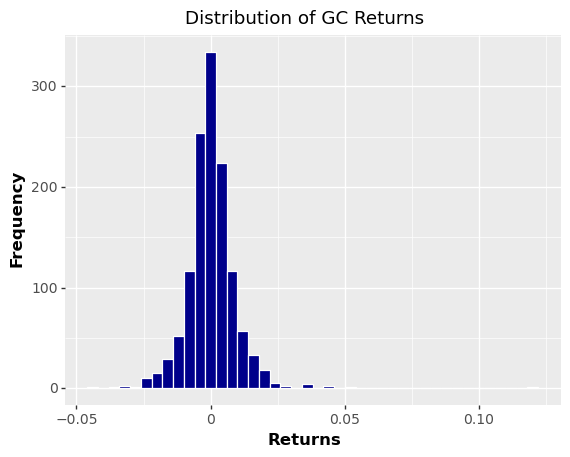

<ggplot: (703763631)>

In [119]:
hist1 = (ggplot(commodities_price_returns[['OWF/CMX_GC_GC']].dropna(), aes(x='OWF/CMX_GC_GC'))
         + geom_histogram(binwidth=.004, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of GC Returns')
        )
hist1

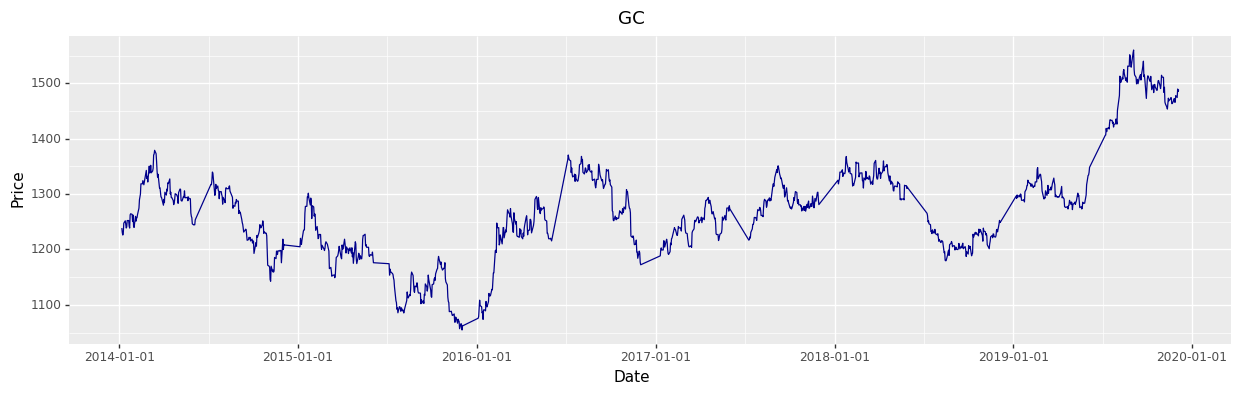

<ggplot: (704130799)>

In [126]:
gc = (ggplot(prices[['OWF/CMX_GC_GC']], aes(x=prices.index, y='OWF/CMX_GC_GC'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Price', title='GC')
       )
gc

In [113]:
pd.concat([commodities_price_returns[['OWF/CMX_GC_GC']].dropna().describe(), tail_statistics(commodities_price_returns[['OWF/CMX_GC_GC']].dropna())]).T

,count,mean,std,min,25%,50%,75%,max,VaR (0.05),CVaR (0.05),Skewness,Kurtosis
OWF/CMX_GC_GC,1280.0,0.000185,0.0092,-0.044598,-0.004185,0.0,0.004292,0.120691,-0.013317,-0.019209,2.013037,25.278942


Some observations:
- GC has a large kurtosis and positive skewness. This makes sense as gold is a safe haven asset
- The distribution is symmetrical around 0 (as with most returns).

***

**4.3 Currencies**

Currencies will be analyzed next to see if there are any trends between currency spot rates and VIX returns.

In [128]:
currencies = ['CUR/GBP', 'CUR/AUD', 'CUR/CAD', 'CUR/CHF', 'CUR/CNY', 'CUR/EUR', 'CUR/HKD', 'CUR/INR', 'CUR/JPY', 'CUR/MXN']
currency_correlations = pd.DataFrame(columns=['Unconditional Correlation to VIX','Conditional Correlation to VIX'])
for currency in currencies:
    returns = fetch_quandl(currency, begin_date='2014-01-01', end_date='2019-12-31')['RATE'].pct_change()
    vix_returns = all_data['VIX Returns']
    currency_correlations.loc[currency,'Unconditional Correlation to VIX'] = (returns).corr(vix_returns)
    currency_correlations.loc[currency,'Conditional Correlation to VIX'] = (returns).corr(vix_returns[vix_returns > 0.1])
display(currency_correlations)

,Unconditional Correlation to VIX,Conditional Correlation to VIX
CUR/GBP,0.106423,0.176684
CUR/AUD,0.119875,0.017145
CUR/CAD,0.086371,0.018985
CUR/CHF,-0.036571,-0.042449
CUR/CNY,0.029487,0.032235
CUR/EUR,0.007884,0.042833
CUR/HKD,0.053986,-0.031422
CUR/INR,0.146677,0.113031
CUR/JPY,-0.168689,-0.181138
CUR/MXN,0.182745,0.063029


Based on the spot rate correlations above, it can be seen that JPYUSD and GBPUSD have larger correlations in magnitude, especially when it's conditional on VIX. In other words, GBPUSD and JPYUSD are pairs that can potentially be traded. Here, let's focus on JPYUSD. 

A negative correlation is seen meaning that when VIX has positive returns, JPYUSD has negative returns. This means that JPYUSD should be shorted when high VIX returns are expected. In other words, JPY should be sold while USD should be bought. 

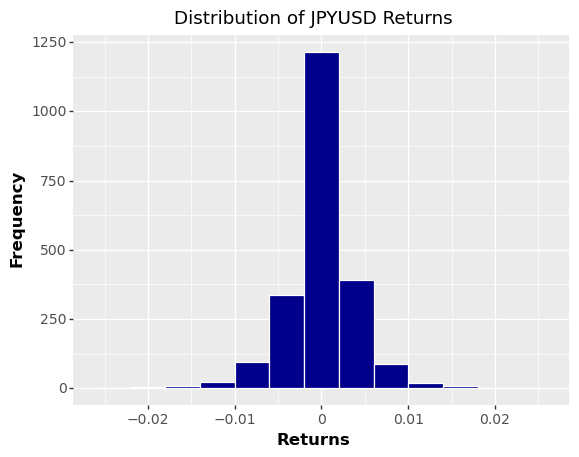

<ggplot: (704365409)>

In [140]:
usdjpy_returns = pd.DataFrame(data=fetch_quandl('CUR/JPY', begin_date='2014-01-01', end_date='2019-12-31')['RATE'].pct_change())
usdjpy_returns = usdjpy_returns.dropna()
hist1 = (ggplot(usdjpy_returns, aes(x='RATE'))
         + geom_histogram(binwidth=.004, color='white', fill='darkblue')
         + theme(axis_text=element_text(size=10), 
                 axis_title=element_text(size=12, face='bold'))
                + labs(x='Returns', y='Frequency', title='Distribution of JPYUSD Returns')
        )
hist1

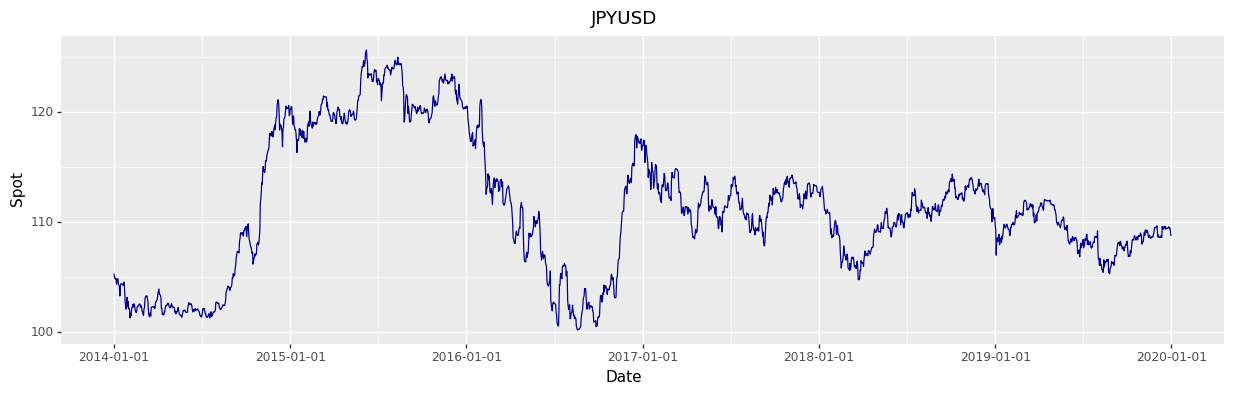

<ggplot: (697557749)>

In [139]:
jpy_spot = fetch_quandl('CUR/JPY', begin_date='2014-01-01', end_date='2019-12-31')['RATE'].to_frame()
jpy = (ggplot(jpy_spot, aes(x=jpy_spot.index, y='RATE'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Spot', title='JPYUSD')
       )
jpy

In [144]:
pd.concat([usdjpy_returns.describe(), tail_statistics(usdjpy_returns)]).T

,count,mean,std,min,25%,50%,75%,max,VaR (0.05),CVaR (0.05),Skewness,Kurtosis
RATE,2189.0,0.000023,0.003983,-0.025535,-0.001545,0.0,0.001746,0.02338,-0.006628,-0.009889,-0.318292,5.170454


Some observations: 
- The distribution appears to be relatively normal. 
- The kurtosis is not as high when compared to other currency pairs / asset classes

***

**4.4 Bonds**

Finally, let's look at the last asset class: fixed income bonds. More specifically, let's look at correlations between US treasuries and the VIX. 

In [145]:
bond_data = fetch_quandl('YC/USA10Y', begin_date='2014-01-02', end_date='2019-12-31')
bond_data['Returns'] = bond_data['Rate'].pct_change()
corr = bond_data['Returns'].corr(all_data['VIX Returns'])
print(f'The correlation of changes in bond yields to VIX is: {round(corr, 5)}')

The correlation of changes in bond yields to VIX is: -0.30173


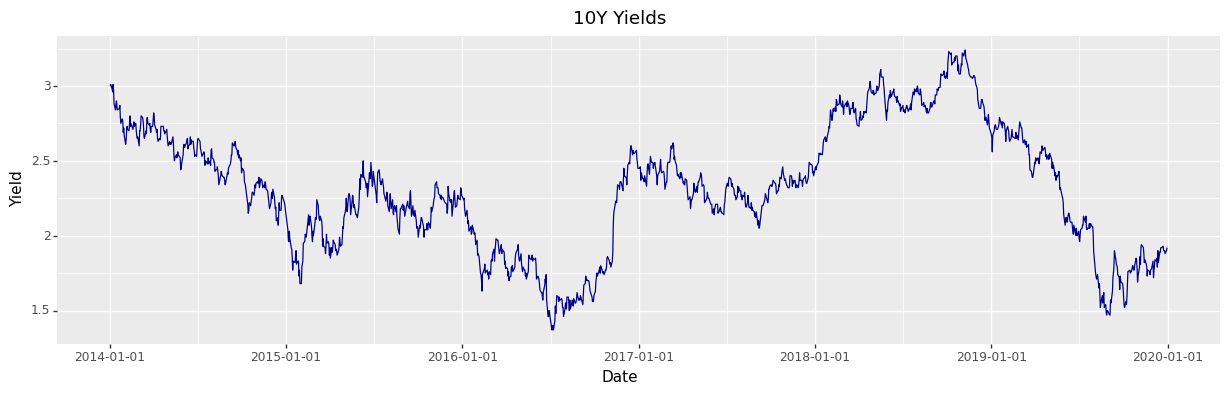

<ggplot: (704418195)>

In [149]:
bnds = (ggplot(bond_data[['Rate']], aes(x=bond_data.index, y='Rate'))
        + geom_line(color='darkblue')
        + theme(figure_size=(15, 4))
        + labs(x='Date', y='Yield', title='10Y Yields')
       )
bnds

It can be seen that bond yield changes are negatively correlated to VIX returns (unconditionally). This means that if VIX returns are positive, bond yield changes would be expected to be negative. Since bond yields are inversely correlated to bond price, this would mean that the price of bonds would go up. This makes sense as if panic is in the market, people are likely to go to safer assets.

***

# 5 Trading Strategy

In this section, certain parameters of the trading strategy will be summarized. It's important to note that some of this is subject to change depending on new research / optimizations conducted within the next week.

The premise of the trading strategy is to capitalize on volatility in the market, more specifically, equity indices. VIX is an index for volatility of S&P options and can be thought of a forward-looking perspective on the next month's volatility. As a result, ability to predict VIX can lead to profits, especially with the usage of options. Options are unique in that they are derivatives of the underlying stock and have interesting properties. These properties are known as the greeks and describe how the option's price moves depending on parameters such as the stock, or here, volatility.

First, the ARIMA model will be used to predict the returns of VIX in the next day. If the return is greater than some threshold (for now, let's say +- 7%), then the strategy will tell us to enter a long position on volatility or a short position. With this, there are 5 different asset classes that can be used. The stock and the option will be the predominant asset in our strategy as it can hedge market movements. This is done with delta hedging. The option has some delta and as a result, if the option is purchased, then the underlying is shorted such that the delta is equal to 0. In practice, the delta won't be exactly equal to 0 but it will be close.

In addition, futures, bonds, and currencies will be added to the strategy in order to hopefully capitalize on increased volatility as well as increase diversification. The trading strategy essentially holds a small portfolio of different asset classes over a few days. These assets were determined from the data analysis above. These assets are gold, JPYUSD, and the 10year bonds. More specifically, the strategy will tell us to buy gold and 10year bonds and to short the JPYUSD pair. If the model tells us that volatility is predicted to decrease, the positions would be reversed. Since VIX is known for its large skewness, the signals will only be enforced when they're above a certain magnitude. These magnitudes will be dynamically calculated based on a rolling / expanding quantile (as mentioned earlier, this needs to be implemented). This should hopefully mitigate the large tail risk when dealing with VIX. 

Position sizing will be determined based on an N day rolling volatility weighting system. If there is higher volatility in the previous days, we will make the assumption that there will continue to be higher volatility and have a larger position in options. This will be further researched for the final copy. If buying volatility, we will purchase 1000 * (1 + rolling n day volatility of SPY) worth of ATM call options. The choice of ATM call options is to make things simple in that the delta of an ATM option is always around 0.5. We will then short an amount of SPY that will allow us to be mostly delta neutral. For the other 3 assets (gold, bonds, JPYUSD pair), we will buy 50000 * (1 + n day correlation of assets and VIX returns). This allows us to buy more equities if they are more correlated to VIX. In other words, if we think VIX is going to have positive returns, we will buy more assets that are correlated to it in the hopes that it will increase our gains. This should also add diversification, though these effects will be later examined.

The position sizings were also determined with the thoughts of liquidity. Since options can be purchased at the close (about 15 minutes after close for SPY/SPX options), we have limited the number of option contracts that can be purchased. We will assume that we can buy this amount of options, which may not be a bad assumption as the open interest of ATM options is quite high. For the short positions, we will assume LIBOR as the rate that we must pay. With all these considerations, we expect our position size to be around 200-300k in gross notional, though this can be scaled down (as long as the proportions remain the same). The initial capital that is required to use this strategy is estimated to be around 2 million dollars. As a result, the maximum amount we can lose on the account is 10% of the entire account size. This is only an estimation as there will also be short positions which could increase this loss as the strategy is leveraged.

In terms of managing the trade, VIX is typically decaying and the moves aren't prolonged. As a result, we will exit trades within 3 days or if we obtain the opposite signal, in which we will reverse the position. VIX is naturally decaying and as a result, will slowly lose value. However, the relationship between the decaying nature of VIX and IV of SPY options has yet to be researched. This will be the first implementation. The other implementation will be to slowly exit positions over time rather than exiting it within 3 days. For example, if we obtain positive returns the following day, we will exit 50% of the position and then hold onto the positions and move the stop loss up. Finally, we will also look at risk:reward systems. For example, instead of slowly scaling out, we will set a designated stop loss of some percentage (i.e 2% of the position) and will exit the position at 4 or 6%. Even with a 50% win rate, if this is achieved, then you can still profit as the expected value is positive.

Since we are holding several asset classes, the various risks must be considered. Since we are mostly delta hedged, our risk to market movement is minimal. However, we will not be rebalancing our portfolio and as a result, the delta hedge will stray away, especially if movements occur. Since we are only holding for a short time frame, this should mitigatea majority of the delta risk. When looking at the currencies, bonds, and gold futures, we are exposed to interest rate risk and potentially unexpected events. Gold is a safe haven asset and can increase in value when inflation increases. Similarly, it can increase (as well as currencies) if there is some unexpected macroeconomic event. Since our holding durations is not very long, this interest rate / unexpected event risk is not too high.

***

# 6 Future Work

For the remainder of the project, there are a number of things to do:

- redo optimization (shift economic events and make it contemparaneous)
- use rolling quantiles to determine model thresholds
- look into more features 
- backtest the strategy 
- compare strategy to benchmarks
- compare ARIMA model to other time series models
- implement risk:reward / risk management systems to the trading strategy

***

# 7 Works Cited

[Ahoniemi, Katja. Modeling and forecasting implied volatility. Helsinki School of Economics, 2009.](https://core.ac.uk/download/pdf/14912922.pdf)

[Jubinski, Daniel & Lipton, Amy. (2013). VIX, Gold, Silver, and Oil: How do Commodities React to Financial Market Volatility? Journal of Accounting and Finance. 13. 70.](http://www.na-businesspress.com/jaf/jubinskid_web13_1_.pdf)